# Bert Hybrid Model: A hybrid model for sentiment analysis taking into account textual content and metadata on twitter.
 <hr>



By: Alejandro Serrano

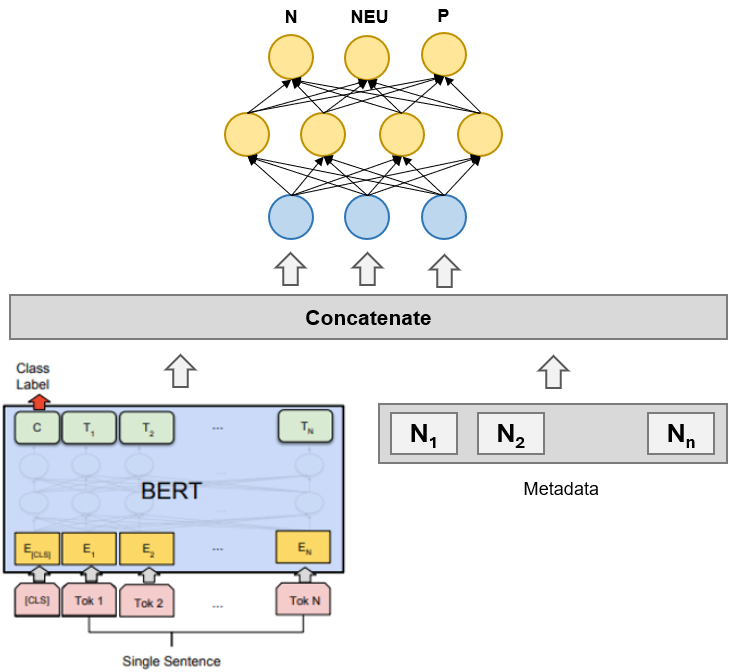

The BERT model allows highly efficient extraction of contextual features in texts, while the MLP-based model allows extraction of features and correlations from metadata. The combination of these models allows to analyse sentiment in social networks taking into account both the metadata of tweets and their textual content.

Import Libraries:

In [1]:
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate, BatchNormalization

from transformers import BertTokenizer, TFBertModel, AdamWeightDecay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pandas.read_csv('/content/drive/MyDrive/Nueva carpeta/tweets_dataset.csv', index_col=0)

In [4]:
df.tail(6)

,tweet_id,user,parent_id,tree_name,text,polarity,favorite_count,retweet_count,lang,user_followers_count,user_friends_count,user_favourites_count,user_statuses_count,user_verified,user_has_extended_profile,user_is_translator,user_protected,user_default_profile,preprocessed
6073,1644152239416549376,colaboralES,1644151172100497409,ia_trees/tree_246,"@BorisEscolan Podría ser, aunque si haces la m...",NEU,0,0,es,367,16,259,1877,0,0,0,0,1,podria ser aunque si haces la misma pregunta d...
6074,1648399247836950529,mansantillan,1648394471808049172,ia_trees/tree_1096,@satelena Bueno eso al final es tema de contex...,NEU,0,0,es,125,806,1123,1887,0,1,0,0,1,bueno eso al final es tema de contexto que ges...
6075,1648815958423662594,Gabhyxx,-1,elon_trees/tree_226,@AhsokaNoSekai Elon Musk be like:\r\n\r\nPágam...,NEU,2,0,es,43,573,190170,66613,0,0,0,0,0,Elon Musk be like pagame de dejare editar test...
6076,1648916123792834569,RedTeaMx,1648899509785690114,elon_trees/tree_44,@mario_campa Por qué “alarmarse” por una decis...,N,0,0,es,119,3537,16044,12892,0,1,0,0,1,por que alarmarse por una decision corporativa...
6077,1649221354149883904,josepeguero,1649211943973015554,elon_trees/tree_425,@Butterfly7118 👍,P,1,0,und,93072,5547,5359,230727,0,0,0,0,0,pulgar hacia arriba
6078,1647843141246959618,gonz_chaves,-1,ia_trees/tree_811,Esto se publicaba el pasado 29 de Marzo.\r\n\r...,NEU,0,0,es,1324,322,4809,33554,0,0,0,0,0,esto se publicaba el pasado de marzo expertos ...


Drop unnecessary columns

In [5]:
df = df.drop(["tweet_id","parent_id","tree_name", "lang", "user", "text"], axis=1)
df = df.dropna(subset=['preprocessed'])
ylabel = {'N': 0, 'NEU': 1, 'P': 2}
df['polarity'] = df['polarity'].map(ylabel)

In [6]:
values_count = {
    'user_verified': df['user_verified'].value_counts(),
    'user_has_extended_profile': df['user_has_extended_profile'].value_counts(),
    'user_is_translator': df['user_is_translator'].value_counts(),
    'user_protected': df['user_protected'].value_counts(),
    'user_default_profile': df['user_default_profile'].value_counts()
}

for column, count in values_count.items():
    print(f"Unique values for {column}:\n{count}\n")

Unique values for user_verified:
0    5712
1     235
Name: user_verified, dtype: int64

Unique values for user_has_extended_profile:
1    4382
0    1565
Name: user_has_extended_profile, dtype: int64

Unique values for user_is_translator:
0    5947
Name: user_is_translator, dtype: int64

Unique values for user_protected:
0    5947
Name: user_protected, dtype: int64

Unique values for user_default_profile:
1    3379
0    2568
Name: user_default_profile, dtype: int64



Drop columns with one single value

In [7]:
df = df.drop(['user_is_translator', 'user_protected'], axis=1)

Simple data visualization

1    3754
0    1247
2     946
Name: polarity, dtype: int64


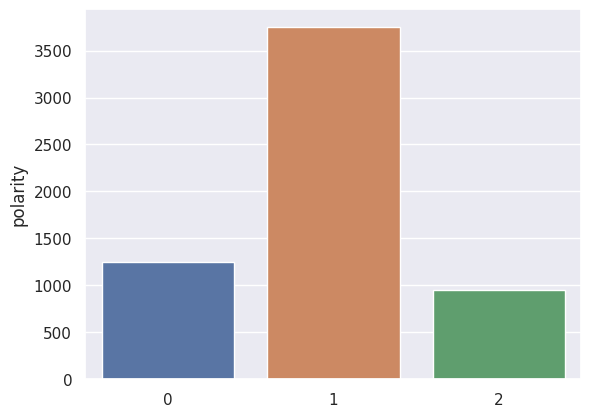

In [8]:
sns.set_theme(style="darkgrid")
sns.barplot(x=df['polarity'].value_counts().index, y=df['polarity'].value_counts())
print(df['polarity'].value_counts())

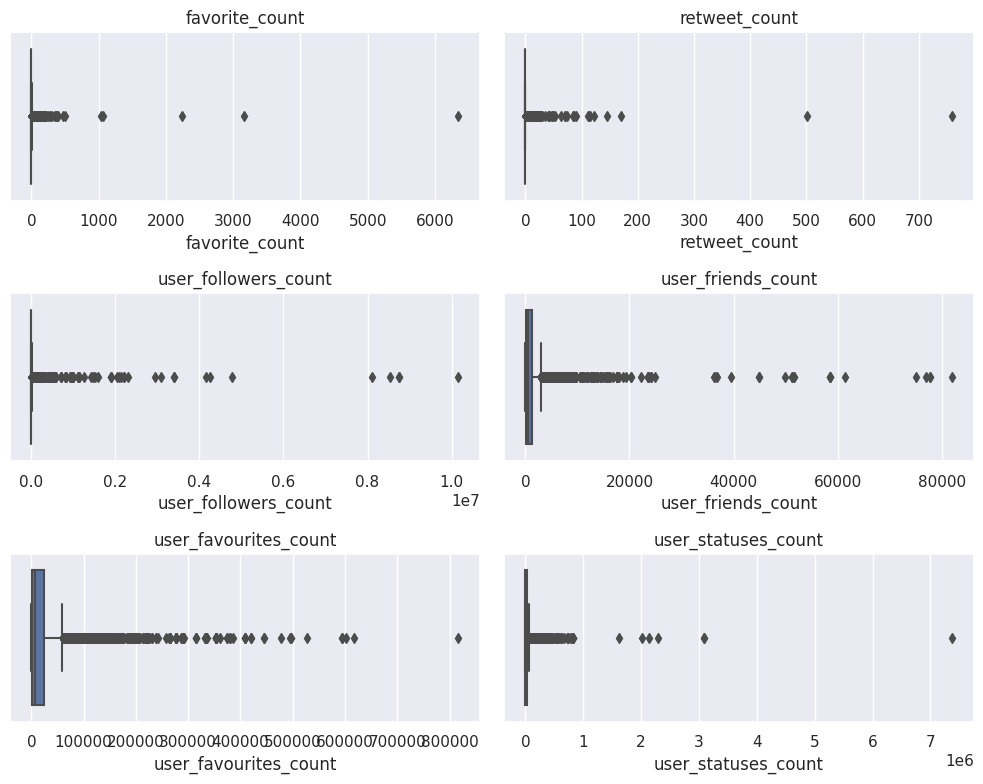

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(10,8))
columns = ['favorite_count', 'retweet_count', 'user_followers_count', 'user_friends_count', 'user_favourites_count', 'user_statuses_count']
axs = axs.ravel()

# Iterar sobre cada columna y crear un histograma
for i, col in enumerate(columns):
    sns.boxplot(x=df[col], ax=axs[i])
    axs[i].set_title(col)

# plt.savefig('boxplot.png', dpi=300)
# Ajustar la distancia entre los gráficos
fig.tight_layout()
plt.show()


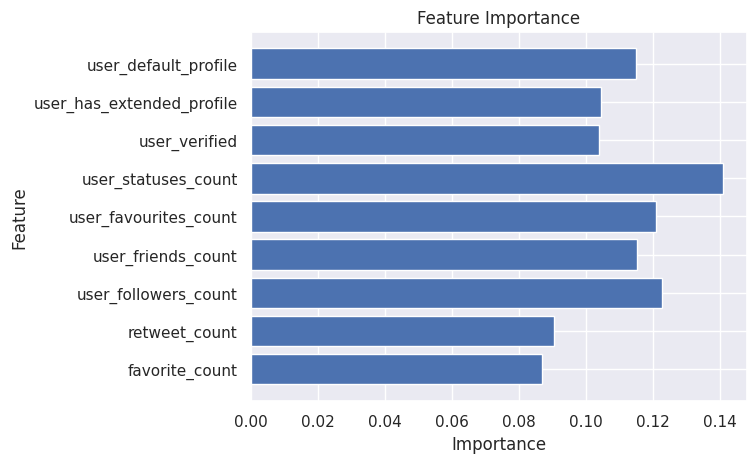

In [10]:
XGB = XGBClassifier()
X = df.drop(['polarity', 'preprocessed'], axis=1)
y = df['polarity']
XGB.fit(X, y)

# Importancia de las características
importances = XGB.feature_importances_
# Visualización de las características
plt.barh(X.columns, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [11]:
df = df.drop(['retweet_count', 'favorite_count'], axis=1)

In [ ]:
xtrn, xaux, ytrn, yaux = train_test_split(df.loc[:, df.columns != "polarity"], df['polarity'], test_size=0.2, random_state=42)
xval, xtst, yval, ytst = train_test_split(xaux, yaux, test_size=0.5, random_state=42)

In [ ]:
scaler = PowerTransformer()

columns_to_scale = ['user_followers_count', 'user_friends_count', 'user_favourites_count', 'user_statuses_count']
xtrn[columns_to_scale] = scaler.fit_transform(xtrn[columns_to_scale])
xtst[columns_to_scale] = scaler.transform(xtst[columns_to_scale])
xval[columns_to_scale] = scaler.transform(xval[columns_to_scale])

In [ ]:
class HybridBert(tf.keras.Model):
    def __init__(self, num_classes):
        super(HybridBert, self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
        self.bert = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
        self.flatten = Flatten()
        self.batch_norm = BatchNormalization()
        self.dense = Dense(8, activation='relu')
        self.concat = Concatenate()
        self.dense1 = Dense(32, activation='relu')
        self.dropout1 = Dropout(0.1)
        self.dense2 = Dense(8, activation='relu')
        self.dropout2 = Dropout(0.1)
        self.out = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        input_ids, attention_mask, numerical_inputs = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs[0]
        cls_output = self.flatten(cls_output)
        cls_output = self.batch_norm(cls_output)
        cls_output = self.dense(cls_output)
        concat = self.concat([cls_output, numerical_inputs])
        mlp = self.dense1(concat)
        mlp = self.dropout1(mlp)
        mlp = self.dense2(mlp)
        mlp = self.dropout2(mlp)
        out = self.out(mlp)

        return out

    def tokenize_dataset(self, dataset, max_len):
        return self.tokenizer(dataset,
            max_length=max_len,
            add_special_tokens=True, #Adds CLS, SEP y PAD
            truncation=True, #Truncate text if greater than max_length
            return_token_type_ids=False,  #Adds 0 to tokens and 1 to padding
            padding='max_length',
            return_attention_mask=True,
            return_tensors="tf")

    def tf_dataset(self, text_inputs, numerical_inputs, labels, tokenizer_max_len, batch_size, num_classes, shuffle=True, buffer_size=8):
        tokenized_text = self.tokenize_dataset(text_inputs, tokenizer_max_len)
        numerical_inputs = tf.convert_to_tensor(numerical_inputs, dtype=tf.float32)
        labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)
        dataset = tf.data.Dataset.from_tensor_slices(((tokenized_text['input_ids'], tokenized_text['attention_mask'], numerical_inputs), labels))
        if shuffle:
            dataset = dataset.shuffle(buffer_size = buffer_size, reshuffle_each_iteration = True).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
        else:
            dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

In [ ]:
model = HybridBert(3)
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = AdamWeightDecay(learning_rate=2e-05)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

train_dataset = model.tf_dataset(xtrn['preprocessed'].to_list(),
                                 xtrn.loc[:, xtrn.columns != "preprocessed"].to_numpy().astype('float32'),
                                 ytrn, 128, 8, 3, shuffle=True)
test_dataset = model.tf_dataset(xtst['preprocessed'].to_list(),
                                xtst.loc[:, xtst.columns != "preprocessed"].to_numpy().astype('float32'),
                                ytst, 128, 8, 3, shuffle=True)
val_dataset = model.tf_dataset(xval['preprocessed'].to_list(),
                               xval.loc[:, xval.columns != "preprocessed"].to_numpy().astype('float32'),
                               yval, 128, 1, 3, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/537M [00:00<?, ?B/s]

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


595/595 [==============================] - 199s 291ms/step - loss: 0.9118 - accuracy: 0.5796 - val_loss: 0.7891 - val_accuracy: 0.6336
Epoch 2/10
595/595 [==============================] - 169s 284ms/step - loss: 0.7388 - accuracy: 0.6847 - val_loss: 0.7061 - val_accuracy: 0.7294
Epoch 3/10
595/595 [==============================] - 169s 284ms/step - loss: 0.6222 - accuracy: 0.7475 - val_loss: 0.8021 - val_accuracy: 0.6319
Epoch 4/10
595/595 [==============================] - 165s 277ms/step - loss: 0.5067 - accuracy: 0.8039 - val_loss: 0.6957 - val_accuracy: 0.7361
Epoch 5/10
595/595 [==============================] - 166s 279ms/step - loss: 0.4304 - accuracy: 0.8304 - val_loss: 0.6849 - val_accuracy: 0.7479
Epoch 6/10
595/595 [==============================] - 168s 283ms/step - loss: 0.3677 - accuracy: 0.8606 - val_loss: 0.6914 - val_accuracy: 0.7630
Epoch 7/10
595/595 [==============================] - 165s 277ms/step - loss: 0.3090 - accuracy: 0.8833 - val_loss: 1.0429 - val_accura

In [ ]:
model.evaluate(test_dataset)

75/75 [==============================] - 7s 87ms/step - loss: 1.2240 - accuracy: 0.7361


[1.2240008115768433, 0.7361344695091248]

In [ ]:
class BasicBert(tf.keras.Model):
    def __init__(self, num_classes):
        super(BasicBert, self).__init__()
        self.tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
        self.bert = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
        self.flatten = Flatten()
        self.batch_norm = BatchNormalization()
        self.dense = Dense(16, activation='relu')
        self.dense1 = Dense(32, activation='relu')
        self.dropout1 = Dropout(0.1)
        self.dense2 = Dense(8, activation='relu')
        self.dropout2 = Dropout(0.1)
        self.out = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs[0]
        cls_output = self.flatten(cls_output)
        cls_output = self.batch_norm(cls_output)
        cls_output = self.dense(cls_output)
        mlp = self.dense1(cls_output)
        mlp = self.dropout1(mlp)
        mlp = self.dense2(mlp)
        mlp = self.dropout2(mlp)
        out = self.out(mlp)

        return out

    def tokenize_dataset(self, dataset, max_len):
        return self.tokenizer(dataset,
            max_length=max_len,
            add_special_tokens=True, #Añade el CLS, SEP y PAD
            truncation=True, #Trunca el texto si es mayor que el max_length
            return_token_type_ids=False,  #Añade el 0 a los tokens y el 1 a los padding
            padding='max_length', #Añade el 0 a los tokens y el 1 a los padding
            return_attention_mask=True, #Añade el 1 a los tokens y el 0 a los padding, return_tensors="tf")
            return_tensors="tf")

    def tf_dataset(self, text_inputs, labels, tokenizer_max_len, batch_size, num_classes, shuffle=True, buffer_size=8):
        tokenized_text = self.tokenize_dataset(text_inputs, tokenizer_max_len)
        labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)
        dataset = tf.data.Dataset.from_tensor_slices(((tokenized_text['input_ids'], tokenized_text['attention_mask']), labels))
        if shuffle:
            dataset = dataset.shuffle(buffer_size = buffer_size, reshuffle_each_iteration = True).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
        else:
            dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

In [ ]:
model = BasicBert(3)
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = AdamWeightDecay(learning_rate=2e-05)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

train_dataset = model.tf_dataset(xtrn['preprocessed'].to_list(),
                                 ytrn, 128, 8, 3, shuffle=True)
test_dataset = model.tf_dataset(xtst['preprocessed'].to_list(),
                                ytst, 128, 8, 3, shuffle=True)
val_dataset = model.tf_dataset(xval['preprocessed'].to_list(),
                               yval, 128, 1, 3, shuffle=False)

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


595/595 [==============================] - 188s 288ms/step - loss: 1.1894 - accuracy: 0.3477 - val_loss: 0.9683 - val_accuracy: 0.5597
Epoch 2/10
595/595 [==============================] - 169s 285ms/step - loss: 1.0542 - accuracy: 0.4902 - val_loss: 0.8345 - val_accuracy: 0.6908
Epoch 3/10
595/595 [==============================] - 172s 289ms/step - loss: 0.9186 - accuracy: 0.6012 - val_loss: 0.7486 - val_accuracy: 0.6824
Epoch 4/10
595/595 [==============================] - 165s 277ms/step - loss: 0.8296 - accuracy: 0.6538 - val_loss: 0.6914 - val_accuracy: 0.7412
Epoch 5/10
595/595 [==============================] - 165s 278ms/step - loss: 0.7686 - accuracy: 0.7004 - val_loss: 0.6420 - val_accuracy: 0.7412
Epoch 6/10
595/595 [==============================] - 165s 277ms/step - loss: 0.6769 - accuracy: 0.7412 - val_loss: 0.8225 - val_accuracy: 0.6773
Epoch 7/10
595/595 [==============================] - 169s 284ms/step - loss: 0.6677 - accuracy: 0.7551 - val_loss: 0.8409 - val_accura

In [ ]:
model.evaluate(test_dataset)

75/75 [==============================] - 7s 88ms/step - loss: 0.9171 - accuracy: 0.7328


[0.9171375632286072, 0.7327731251716614]